## UNECE Machine Learning Project - VITO Pilot Study
# Energy balance statistics

## Notebook 2. Machine learning analysis and results

In this notebook: using the data prepared in notebook 1, the pilot study is executed.

### Read data that was prepared in Notebook 1

In [1]:
import pandas as pd
import feather
import math
import matplotlib.pyplot as plt

data = feather.read_dataframe("data_quarterly_prepared.feather")
# data.info()

In [2]:
data.head()

,EnrgCombustibleFuels,EnrgNuclearNuclear,EnrgHydroHydro,EnrgGeothermalOther,EnrgIndigenousProd,EnrgImportsImports,EnrgExportsExports,EnrgElectricitySupplied,DegreeDays,GrossDomInc,...,GDPChStocks,GDPChInven,GDPAcqui,GDPExtBGoServ,GDPExpor,GDPImpor,Population,SunSpots,quarter,quarterNum
0,10108.0,11087.0,446.0,3.0,21644.0,2420.0,1563.0,22501.0,988.0,62261.4,...,1503.0,1498.0,5.0,1879.0,44573.0,42695.0,10242.0,172.166667,2000Q1,0
1,7739.0,10770.0,357.0,3.0,18869.0,3023.0,1788.0,20104.0,290.0,65046.1,...,1600.0,1593.0,7.0,1704.0,46243.0,44538.0,10245.0,181.800000,2000Q2,1
2,6984.0,11154.0,397.0,3.0,18538.0,2934.0,2019.0,19453.0,75.0,62753.6,...,1288.0,1280.0,8.0,1070.0,45093.0,44024.0,10253.0,193.600000,2000Q3,2
3,7982.0,12737.0,487.0,5.0,21211.0,3267.0,1950.0,22528.0,744.0,68160.5,...,-1055.0,-1063.0,8.0,2155.0,49643.0,47488.0,10265.0,147.666667,2000Q4,3
4,8067.0,11539.0,454.0,4.0,20064.0,3990.0,1035.0,23019.0,1048.0,64317.9,...,1240.0,1232.0,7.0,1508.0,48789.0,47280.0,10271.0,143.300000,2001Q1,4


In [3]:
data.shape

(77, 60)

### Define additional variables

Create extra variables to serve as predictors: the energy variables at the same quarter a year before. Note that this is not possible for the first year. Not to loose this year, we choose to use the values of that year as the ones for the year before.

In [4]:
energyvars = data.columns[0:8]

In [5]:
data['year'] = data['quarter'].str[:4].astype('int')
data['yearquarter'] = data['quarter'].str[5:6].astype('int')
data.head() # check if last 2 columns are OK

,EnrgCombustibleFuels,EnrgNuclearNuclear,EnrgHydroHydro,EnrgGeothermalOther,EnrgIndigenousProd,EnrgImportsImports,EnrgExportsExports,EnrgElectricitySupplied,DegreeDays,GrossDomInc,...,GDPAcqui,GDPExtBGoServ,GDPExpor,GDPImpor,Population,SunSpots,quarter,quarterNum,year,yearquarter
0,10108.0,11087.0,446.0,3.0,21644.0,2420.0,1563.0,22501.0,988.0,62261.4,...,5.0,1879.0,44573.0,42695.0,10242.0,172.166667,2000Q1,0,2000,1
1,7739.0,10770.0,357.0,3.0,18869.0,3023.0,1788.0,20104.0,290.0,65046.1,...,7.0,1704.0,46243.0,44538.0,10245.0,181.800000,2000Q2,1,2000,2
2,6984.0,11154.0,397.0,3.0,18538.0,2934.0,2019.0,19453.0,75.0,62753.6,...,8.0,1070.0,45093.0,44024.0,10253.0,193.600000,2000Q3,2,2000,3
3,7982.0,12737.0,487.0,5.0,21211.0,3267.0,1950.0,22528.0,744.0,68160.5,...,8.0,2155.0,49643.0,47488.0,10265.0,147.666667,2000Q4,3,2000,4
4,8067.0,11539.0,454.0,4.0,20064.0,3990.0,1035.0,23019.0,1048.0,64317.9,...,7.0,1508.0,48789.0,47280.0,10271.0,143.300000,2001Q1,4,2001,1


In [6]:
for v in energyvars:
    # print(v + 'Prv') # the newly defined variables
    for j in range(0, 4):
        data.loc[j,v + 'Prv'] = data.loc[j, v]
    for j in range(4, data.shape[0]):
        data.loc[j,v + 'Prv'] = data.loc[j-4, v]
# data.head(8)
# data.tail(20)

In [7]:
# Check if OK
# data.head(10)
# data.tail(10)

### Study setup overview
- split data in training and test set
- model energy ~ auxiliaries on training data, using a number of different methods and a benchmark
- consider as auxiliaries the economic and weather variables, and observation of previous year
- evaluate methods on test set and compare performance

### Split data in training and test set

In [8]:
trn = data.loc[data['quarterNum'] < 61]
tst = data.loc[data['quarterNum'] >= 61]

In [9]:
tst.shape

(16, 70)

### Prepare for modelling

In [10]:
energyvars # OK, we've got those: the target or dependent variables

Index(['EnrgCombustibleFuels', 'EnrgNuclearNuclear', 'EnrgHydroHydro',
       'EnrgGeothermalOther', 'EnrgIndigenousProd', 'EnrgImportsImports',
       'EnrgExportsExports', 'EnrgElectricitySupplied'],
      dtype='object')

In [11]:
aux = list(data.columns) # should become the auxiliary variables aka predictors aka independent variables aka features

In [12]:
# now exclude variables that are NOT auxiliaries
excl = ['Enrg', 'quarter', 'quarterNum', 'year']
filterFunc = lambda v: not any(x in v for x in excl)
aux = [v for v in aux if filterFunc(v)]
aux.extend(energyvars + 'Prv')  # include previous time period of same quarter one year earlier

In [13]:
# inspect if OK
# aux

### Imports needed for analysis 

In [14]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from itertools import compress
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

### Define a function to compute all methods
Note that during development each method was studied separately. Here, we combine everything in a single function and notebook to allow reproduction of the results in our report.

In [15]:
def computeAll(energy, trn, tst):
    print(energy)
    energyPrv = energy + 'Prv'
    
    # Scaling: important for some methods incl. neural networks
    scalerX = StandardScaler()
    scalerY = StandardScaler()
    scalerX.fit(trn[aux])
    scalerY.fit(trn[energy].values.reshape(-1,1))
    scaledTrnX = scalerX.transform(trn[aux])
    scaledTrnY = scalerY.transform(trn[energy].values.reshape(-1,1))
    scaledTrnDf = pd.DataFrame(np.concatenate((scaledTrnX, scaledTrnY), axis=1),
                          columns=trn[aux + [energy]].columns) 

    # Baseline estimates 
    tstdf = tst[['quarterNum', energy]].copy()
    tstdf.loc[:,'ytrue'] = tstdf.loc[:,energy] # true values
    tstdf.loc[:,'yminus4'] = -1   # value of same quarter 1 year before
    for j in tstdf['quarterNum']:
        tstdf.loc[tstdf['quarterNum']==j,'yminus4'] = data.loc[data['quarterNum']==j,energyPrv]

    # apply same scaling to test data (only transform now, not fit)
    scaledTstX = scalerX.transform(tst[aux])
    scaledTstY = scalerY.transform(tst[energy].values.reshape(-1,1))
    scaledTstDf = pd.DataFrame(np.concatenate((scaledTstX, scaledTstY), axis=1),
                          columns=tst[aux + [energy]].columns) 
    trn = scaledTrnDf
    tst = scaledTstDf
    
    # Linear regression
    linMod = LinearRegression()
    rfe = RFE(estimator=linMod, n_features_to_select=3)  # select top features
    rfe.fit(trn[aux], trn[energy])
    linx = list(compress(aux, rfe.support_))
    linMod.fit(trn[linx], trn[energy])
    tstdf['linmod'] = linMod.predict(tst[linx]) 
    print('selected covariates for linear model: ', linx)

    # Ridge regression
    alpha = np.arange(0.1, 10, 0.1)
    ridge = Ridge()
    parameters = {'alpha': alpha}
    ridgeRegressor = GridSearchCV(ridge, parameters,scoring='neg_mean_squared_error', cv=trn.shape[0])
    ridgeRegressor.fit(trn[aux], trn[energy])
    ridge.alpha = ridgeRegressor.best_params_['alpha']
    ridge.fit(trn[aux], trn[energy])
    tstdf['ridge'] = ridge.predict(tst[aux])
    print('ridge parameter alpha: ', ridge.alpha)
    
    # Lasso regression
    alpha = np.arange(0.001,0.200, 0.005) 
    lasso = Lasso()
    parameters = {'alpha': alpha}
    parameters = {'alpha': alpha, 'max_iter': [1e5]}
    lassoRegressor = GridSearchCV(lasso, parameters, scoring='neg_mean_squared_error', cv=trn.shape[0])
    lassoRegressor.fit(trn[aux], trn[energy])
    lasso.alpha = lassoRegressor.best_params_['alpha']
    lasso.max_iter = 1000000
    lasso.fit(trn[aux], trn[energy])
    tstdf['lasso'] = lasso.predict(tst[aux])
    print('lasso parameter alpha: ', lasso.alpha)
    
    # Random forest
    randF = RandomForestRegressor(n_estimators = 500, min_samples_leaf = 2, random_state = 1) # set random_state for reproducability 
    randF.fit(trn[aux], trn[energy])
    # randF.feature_importances_  # can be compared to regression coefs in ridge and lasso
    tstdf['randomforest'] = randF.predict(tst[aux])
    
    # Neural network (multi layer perceptron)
    mlp = MLPRegressor(activation='relu', hidden_layer_sizes=(4,2), max_iter=20000, alpha = 0.3, random_state = 1) # set random_state for reproducability
    mlp.fit(trn[aux], trn[energy])
    tstdf['mlp'] = mlp.predict(tst[aux])
    
    # Return backtransformed predictions by all methods
    predMethods = ['linmod', 'ridge', 'lasso', 'randomforest','mlp']
    for meth in predMethods:
        tstdf[meth] = scalerY.inverse_transform(tstdf[meth].values.reshape(-1, 1))
    return(tstdf)

### Run all models

In [16]:
# Run on all variables and put results in a dict
results = {}
for myvar in energyvars:
    results[myvar] = computeAll(myvar, trn, tst)

EnrgCombustibleFuels
selected covariates for linear model:  ['EnrgIndigenousProdPrv', 'EnrgImportsImportsPrv', 'EnrgElectricitySuppliedPrv']
ridge parameter alpha:  6.8
lasso parameter alpha:  0.001
EnrgNuclearNuclear
selected covariates for linear model:  ['EnrgIndigenousProdPrv', 'EnrgImportsImportsPrv', 'EnrgElectricitySuppliedPrv']
ridge parameter alpha:  3.0000000000000004
lasso parameter alpha:  0.046
EnrgHydroHydro
selected covariates for linear model:  ['EnrgIndigenousProdPrv', 'EnrgImportsImportsPrv', 'EnrgElectricitySuppliedPrv']
ridge parameter alpha:  9.9
lasso parameter alpha:  0.171
EnrgGeothermalOther
selected covariates for linear model:  ['EnrgIndigenousProdPrv', 'EnrgImportsImportsPrv', 'EnrgElectricitySuppliedPrv']
ridge parameter alpha:  0.6
lasso parameter alpha:  0.001
EnrgIndigenousProd
selected covariates for linear model:  ['GrossDomInc', 'BalPrimInc', 'GrossNatInc']
ridge parameter alpha:  3.2
lasso parameter alpha:  0.026000000000000002
EnrgImportsImports
sel

### Define an ensemble estimate as the average of the ML predictions

In [17]:
methods = ['linmod', 'ridge', 'lasso', 'randomforest', 'mlp']

In [18]:
for myvar in energyvars:
    results[myvar]['ensemble'] = results[myvar][methods].mean(axis=1)

### Plot estimates as series

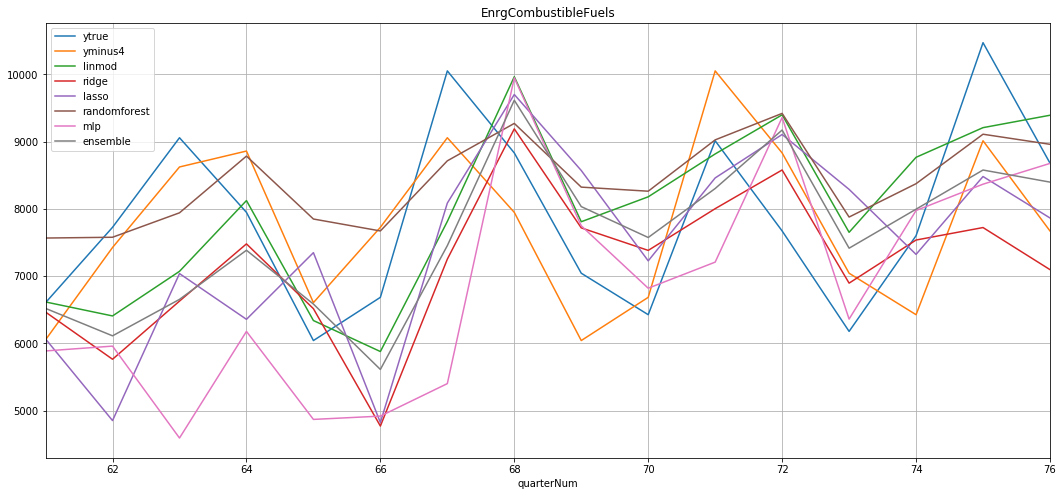

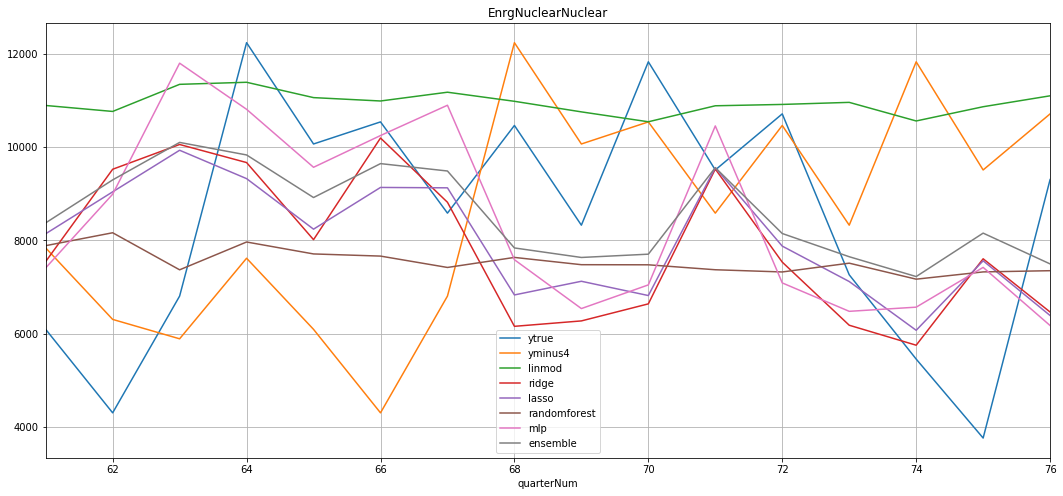

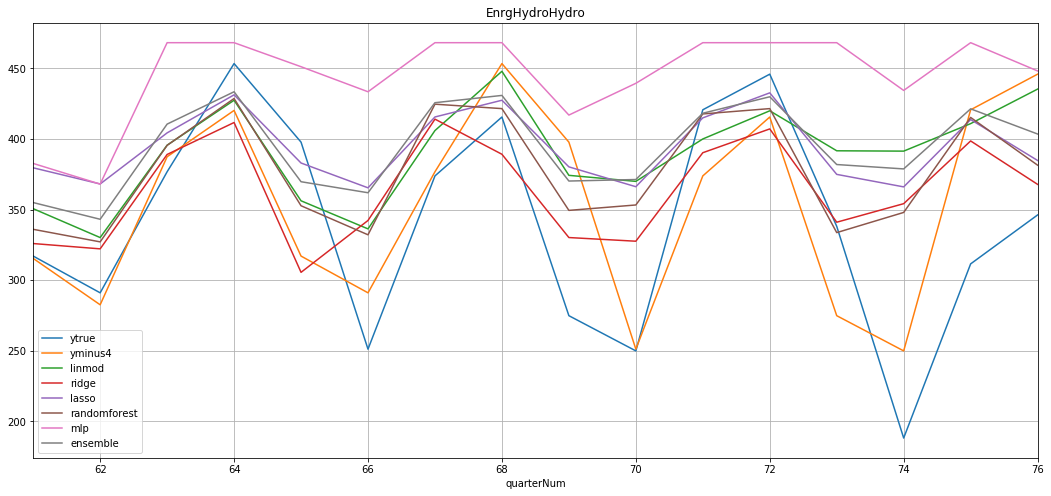

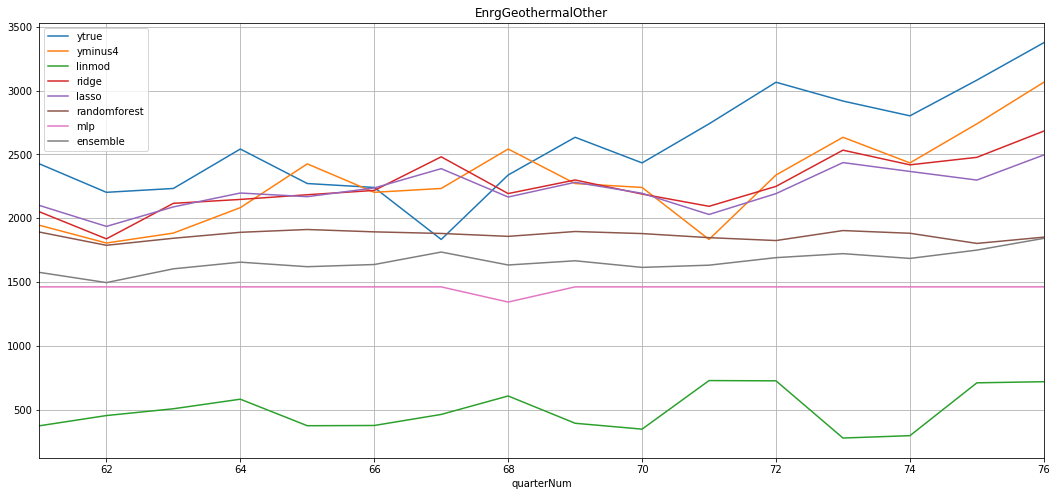

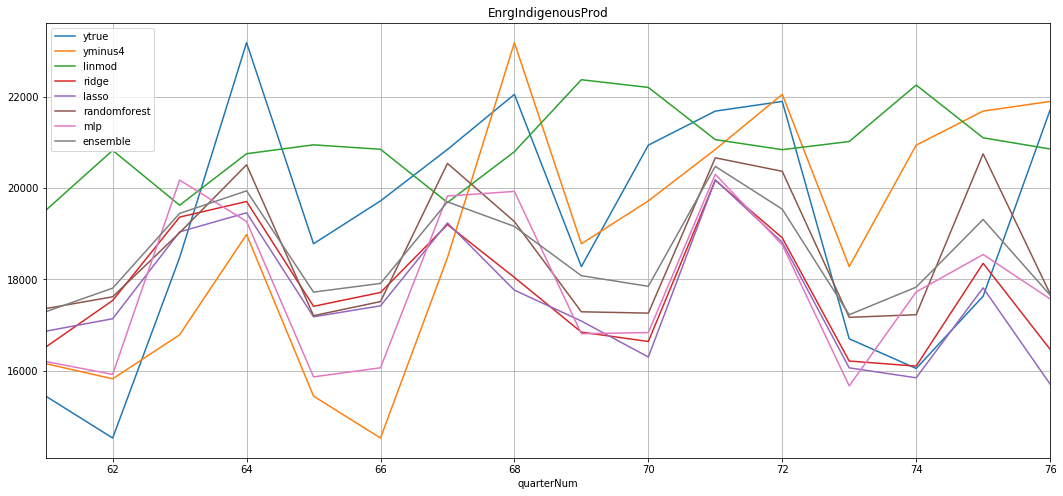

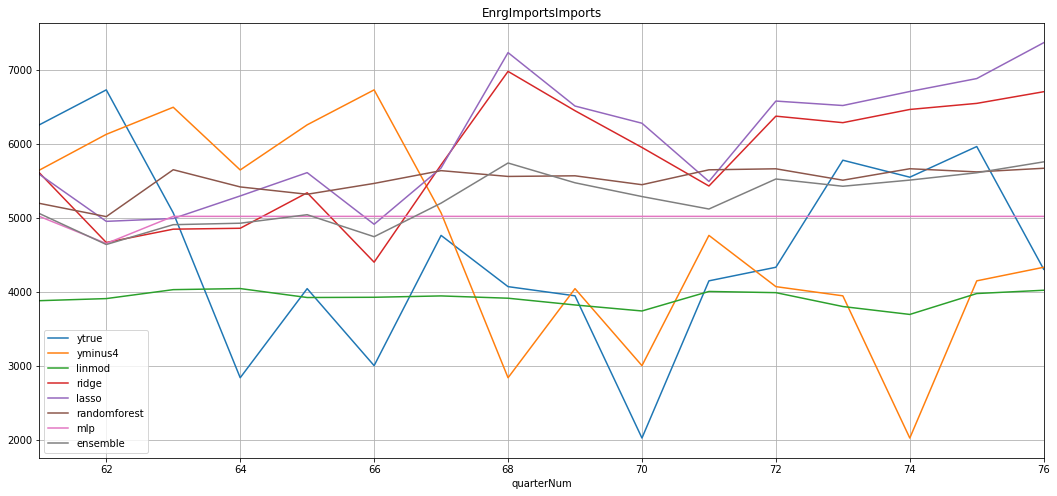

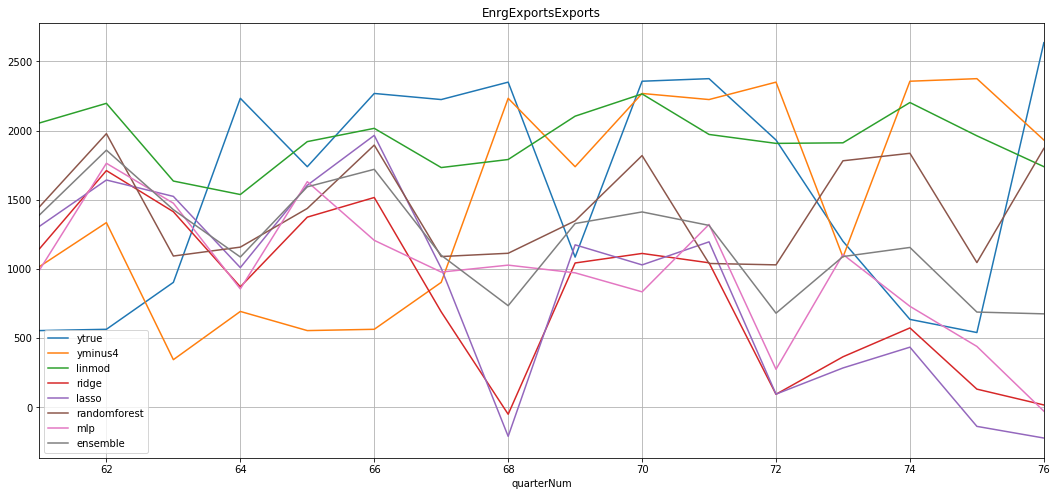

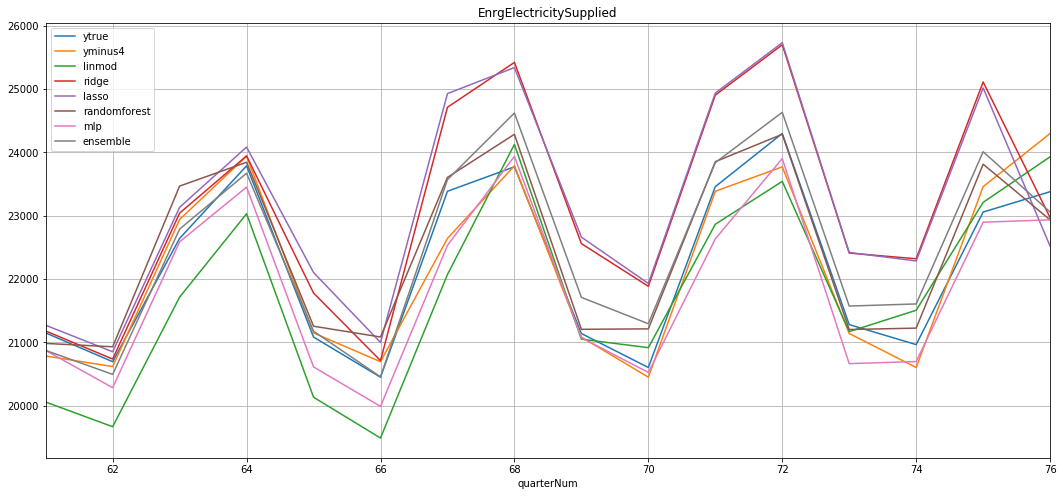

In [19]:
methods = ['yminus4','linmod', 'ridge', 'lasso', 'randomforest', 'mlp','ensemble']
for myvar in energyvars:
    results[myvar].plot(x='quarterNum', y=['ytrue'] + methods, figsize=(18,8), grid=True, title=myvar)
    

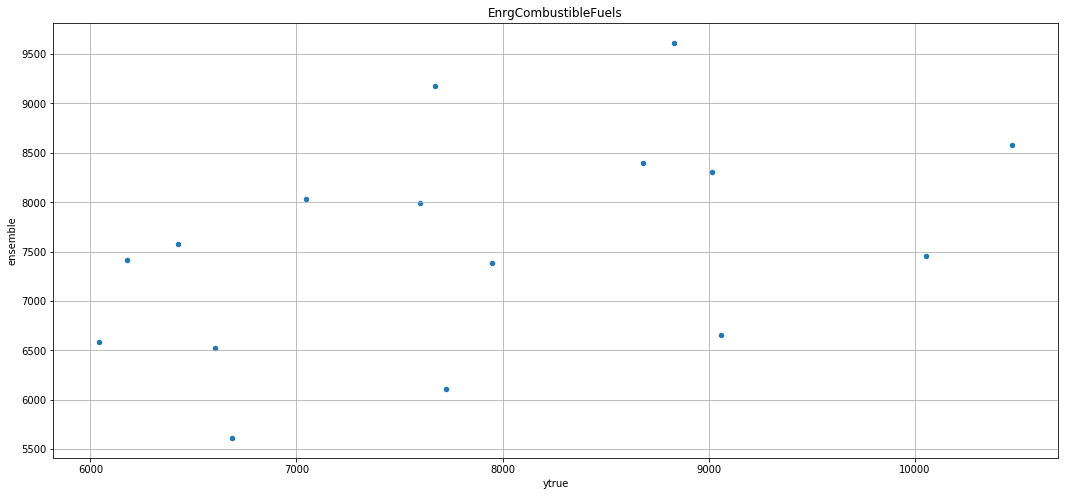

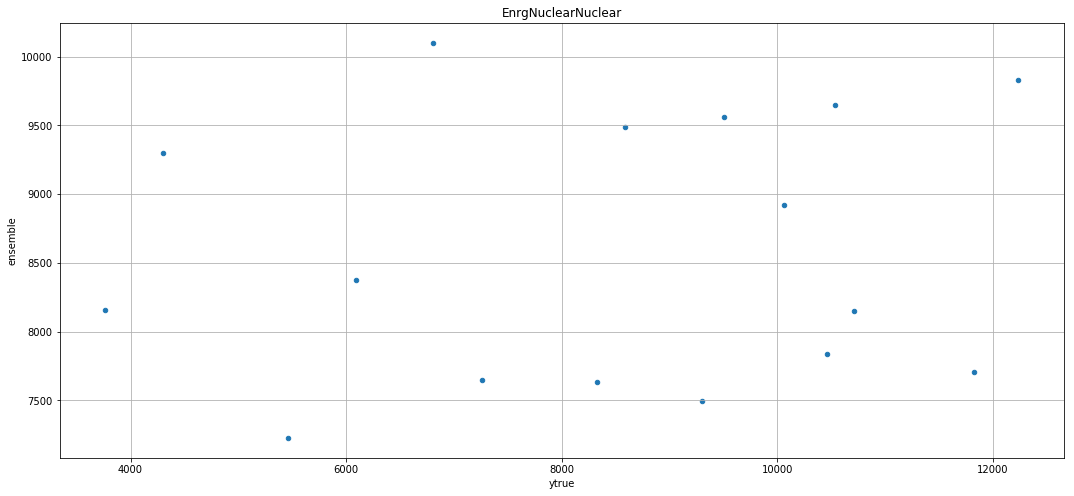

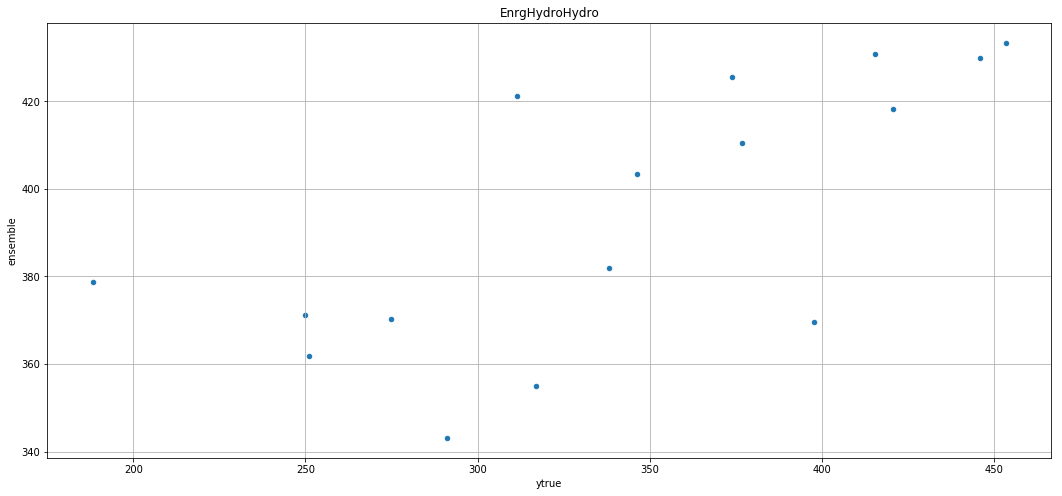

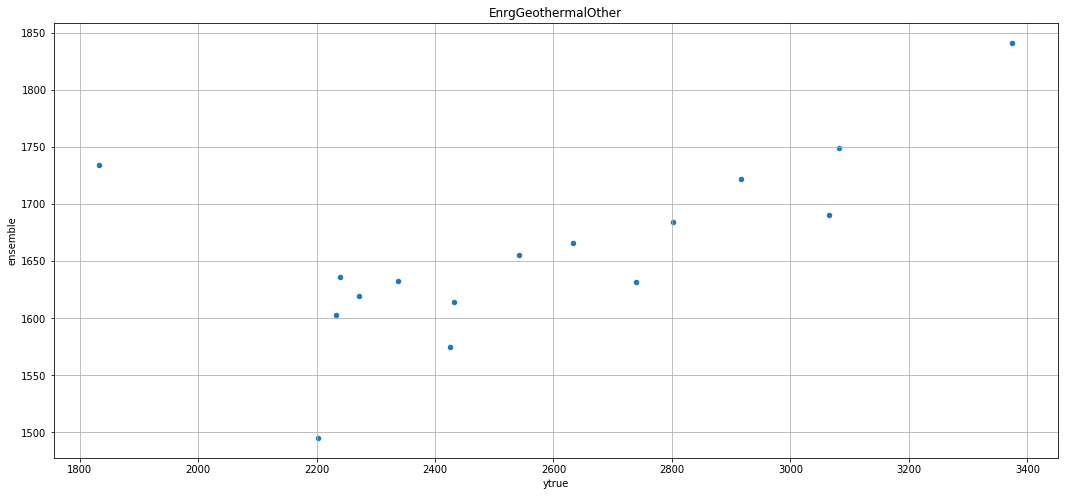

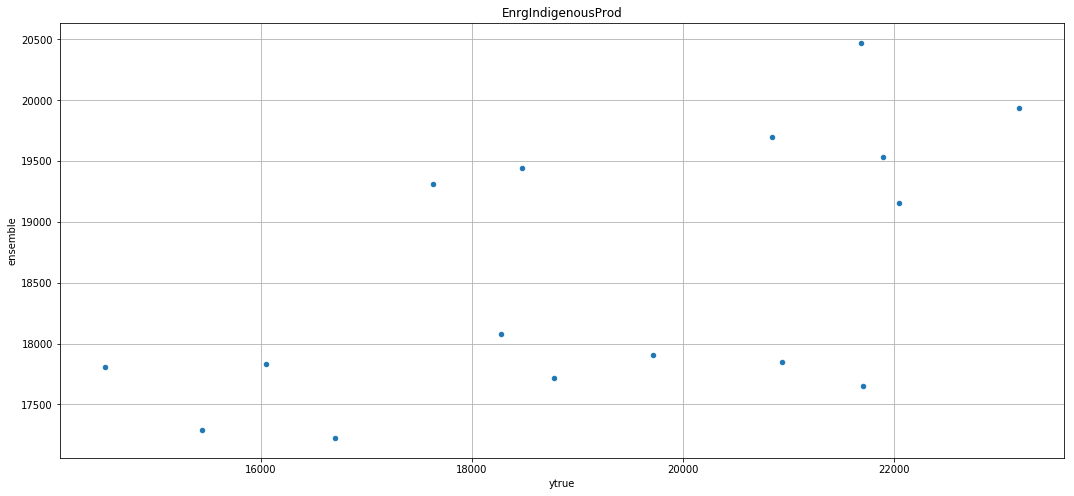

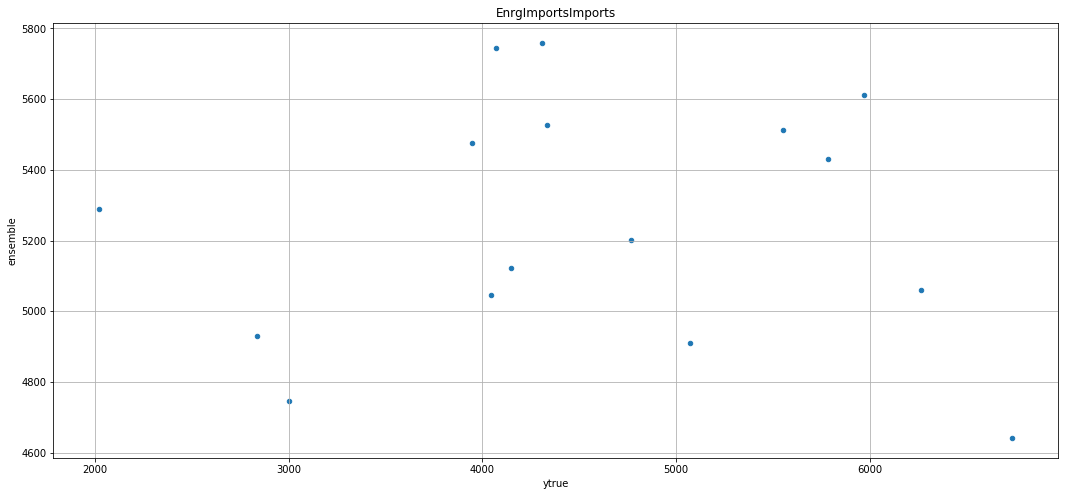

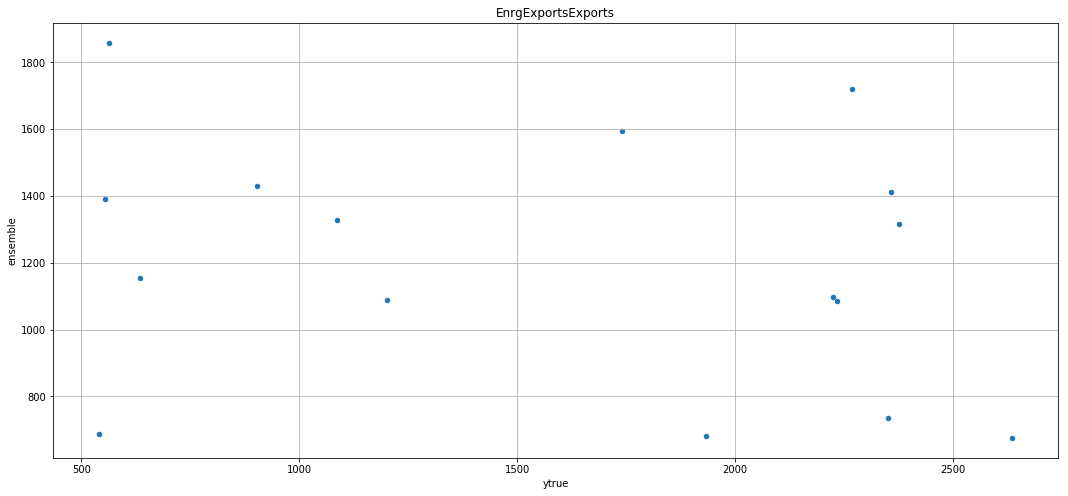

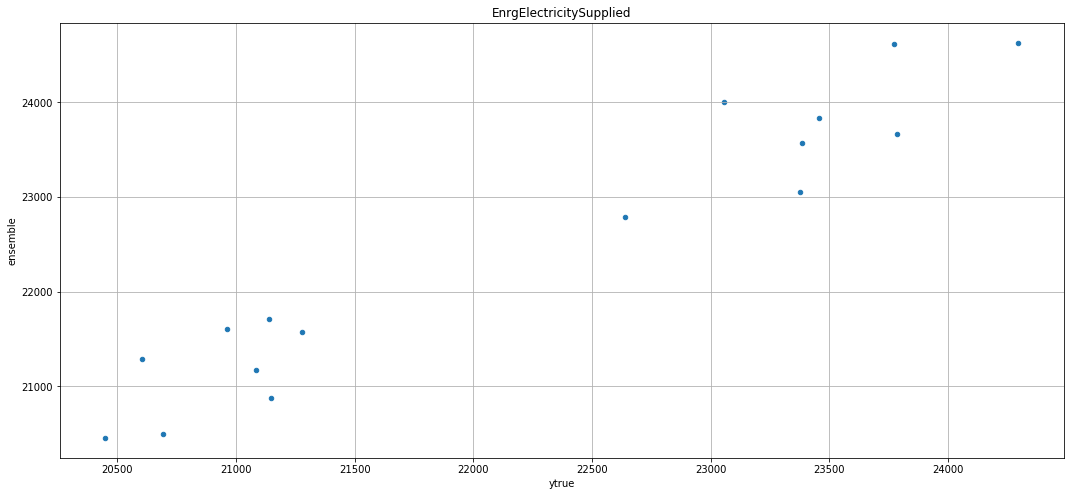

In [20]:
# scatter plots
for myvar in energyvars:
    # results[myvar].plot.scatter(x='quarterNum', y=['ytrue'] + methods, figsize=(18,8), grid=True, title=myvar)
    results[myvar].plot.scatter(x='ytrue', y='ensemble', figsize=(18,8), grid=True, title=myvar)
    


### Compute measures of predictive accuracy
These are computed on the test set. 

In [21]:
def rmse(tstdf,method):
    xx = ((tstdf[method] - tstdf['ytrue'])**2).mean()
    return(math.sqrt(xx))
    
def mae(tstdf,method):
    xx = abs(tstdf[method] - tstdf['ytrue']).mean()
    return(xx)

def me(tstdf,method):
    xx = (tstdf[method] - tstdf['ytrue']).mean()
    return(xx)
   
def mape(tstdf,method):
    xx = (abs(tstdf[method] - tstdf['ytrue']) / abs(tstdf['ytrue'])).mean()
    return(xx)
    
def predacc(v):
    # Construct a dataframe with the results
    predAcc = pd.DataFrame(methods, columns = ['methods'])
    for m in methods:
        predAcc.loc[predAcc['methods']==m,'rmse'] = rmse(results[v],m)
        predAcc.loc[predAcc['methods']==m,'mae'] = mae(results[v],m)
        predAcc.loc[predAcc['methods']==m,'me'] = me(results[v],m)
        predAcc.loc[predAcc['methods']==m,'mape'] = mape(results[v],m)
    return(predAcc)

In [22]:
methods

['yminus4', 'linmod', 'ridge', 'lasso', 'randomforest', 'mlp', 'ensemble']

In [23]:
accuracies = {}
for myvar in energyvars:
    accuracies[myvar] = predacc(myvar)
    print(myvar)
    print(accuracies[myvar])

EnrgCombustibleFuels
        methods         rmse          mae          me      mape
0       yminus4   913.411680   852.782563 -122.971187  0.108228
1        linmod  1251.358271  1063.691996   87.704148  0.134799
2         ridge  1492.254872  1200.347339 -689.528807  0.145638
3         lasso  1570.119360  1408.482561 -402.280699  0.182329
4  randomforest  1188.324741  1038.897636  543.654650  0.141136
5           mlp  2021.938940  1542.495314 -984.956381  0.185117
6      ensemble  1320.812244  1113.600063 -289.081418  0.138393
EnrgNuclearNuclear
        methods         rmse          mae           me      mape
0       yminus4  3283.545643  2614.356063   116.662563  0.378466
1        linmod  3509.223168  2761.162057  2494.505142  0.475150
2         ridge  2901.628222  2369.989490  -580.680701  0.332846
3         lasso  2756.369406  2299.714202  -435.098479  0.321923
4  randomforest  2681.270558  2369.407002  -902.141112  0.315596
5           mlp  2846.970253  2388.717480   -11.178869  0.

### Combine all into a single dataframe and export this

In [24]:
combidf = pd.concat(accuracies)

In [25]:
combidf

methods         rmse          mae  \
EnrgCombustibleFuels    0       yminus4   913.411680   852.782563   
                        1        linmod  1251.358271  1063.691996   
                        2         ridge  1492.254872  1200.347339   
                        3         lasso  1570.119360  1408.482561   
                        4  randomforest  1188.324741  1038.897636   
                        5           mlp  2021.938940  1542.495314   
                        6      ensemble  1320.812244  1113.600063   
EnrgElectricitySupplied 0       yminus4   381.759724   286.884625   
                        1        linmod   750.469954   655.371587   
                        2         ridge  1129.240556   940.536679   
                        3         lasso  1184.600055  1048.235072   
                        4  randomforest   424.543093   340.043851   
                        5           mlp   438.026099   367.424438   
                        6      ensemble   466.337347   378.264234   
EnrgExportsExports      0       yminus4  1031.594321   833.938063   
                        1        linmod   921.353748   761.159286   
                        2         ridge  1299.352867  1065.002965   
                        3         lasso  1318.052280  1061.005133   
                        4  randomforest   887.840401   794.294050   
                        5           mlp  1161.900058   914.021266   
                        6      ensemble   998.391304   842.079525   
EnrgGeothermalOther     0       yminus4   425.381229   373.397625   
                        1        linmod  2104.598215  2075.237090   
                        2         ridge   453.299327   391.401462   
                        3         lasso   495.019864   416.862893   
                        4  randomforest   811.627879   711.861377   
                        5           mlp  1181.845184  1116.498378   
                        6      ensemble   975.460460   911.157454   
EnrgHydroHydro          0       yminus4    60.551362    46.882250   
                        1        linmod    79.844634    63.713924   
                        2         ridge    65.729941    51.459146   
                        3         lasso    77.430039    60.472053   
                        4  randomforest    65.265514    49.335226   
                        5           mlp   121.871282   104.185118   
                        6      ensemble    78.755119    61.613496   
EnrgImportsImports      0       yminus4  1797.444194  1381.706562   
                        1        linmod  1420.050300  1119.558499   
                        2         ridge  1881.691759  1606.364985   
                        3         lasso  2097.893272  1803.614696   
                        4  randomforest  1625.674111  1377.398098   
                        5           mlp  1375.907193  1146.440319   
                        6      ensemble  1479.254859  1222.738469   
EnrgIndigenousProd      0       yminus4  2657.503108  2084.452375   
                        1        linmod  3182.971208  2596.267975   
                        2         ridge  2594.904530  2138.293420   
                        3         lasso  2773.125588  2222.449865   
                        4  randomforest  2253.988177  1944.290034   
                        5           mlp  2508.845864  2208.242725   
                        6      ensemble  2222.303104  1946.630343   
EnrgNuclearNuclear      0       yminus4  3283.545643  2614.356063   
                        1        linmod  3509.223168  2761.162057   
                        2         ridge  2901.628222  2369.989490   
                        3         lasso  2756.369406  2299.714202   
                        4  randomforest  2681.270558  2369.407002   
                        5           mlp  2846.970253  2388.717480   
                        6      ensemble  2579.566829  2145.382731   

                                    me      mape  
EnrgCombustibleFuels    0  -122.971187  0.10822

In [26]:
combidf.to_csv('all_results.csv',sep=';',decimal=',')